In [1]:
#First import the necessary packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
from scipy import stats
import os
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.api as sm2



In [2]:
#Establish the database connection
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()



In [3]:
#making a string to add all the bookies to the query
bookies = "d.B365H, d.B365D, d.B365A, d.BWH, d.BWD, d.BWA, d.IWH, d.IWD, d.IWA, d.LBH, d.LBD, d.LBA, d.PSH, d.PSD, d.PSA, d.WHH, d.WHD, d.WHA, d.SJH, d.SJD, d.SJA, d.VCH, d.VCD, d.VCA, d.GBH, d.GBD, d.GBA, d.BSH, d.BSD, d.BSA"
bookies = bookies.replace('d','m')


#main query gets win loss data and bookie odds
q=("""
        SELECT m.home_team_goal, m.away_team_goal, m.home_team_api_id, {} FROM 
        Match m
        
        """.format(bookies))

df = pd.read_sql_query(q, conn)
df_copy = pd.read_sql_query(q, conn)

#Sets up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal

#Convert odds to implied probability
for column in df.loc[:,'B365H':'BSA']:
    df[column]= df[column]/(1+df[column])
    
#reorder the column to make more sense
cols = list(df.columns)
len(cols)
cols = cols[0:2] + cols[-3:] + cols[2:33]
df = df[cols]

#code from: https://stackoverflow.com/questions/53141240/pandas-how-to-swap-or-reorder-columns
    


In [4]:
#checking for null values
df.isna().sum()



home_team_goal          0
away_team_goal          0
HomeWin                 0
AwayWin                 0
Draw                    0
home_team_api_id        0
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD                  3459
IWA                  3459
LBH                  3423
LBD                  3423
LBA                  3423
PSH                 14811
PSD                 14811
PSA                 14811
WHH                  3408
WHD                  3408
WHA                  3408
SJH                  8882
SJD                  8882
SJA                  8882
VCH                  3411
VCD                  3411
VCA                  3411
GBH                 11817
GBD                 11817
GBA                 11817
BSH                 11818
BSD                 11818
BSA                 11818
dtype: int64

In [5]:
#drop columns with over 5000 null value - 22432 total rows
df.drop(['PSA','PSH','PSD','GBH','GBD','GBA','BSH','BSD','BSA','SJH','SJD','SJA'], axis=1, inplace=True)



In [6]:
#check for null values again
df.isna().sum()


home_team_goal         0
away_team_goal         0
HomeWin                0
AwayWin                0
Draw                   0
home_team_api_id       0
B365H               3387
B365D               3387
B365A               3387
BWH                 3404
BWD                 3404
BWA                 3404
IWH                 3459
IWD                 3459
IWA                 3459
LBH                 3423
LBD                 3423
LBA                 3423
WHH                 3408
WHD                 3408
WHA                 3408
VCH                 3411
VCD                 3411
VCA                 3411
dtype: int64

In [7]:
#Check the shape of the dataframe
df.shape



(25979, 24)

In [8]:
#Drop any row with a null value
df.dropna(inplace=True)



In [9]:
#Check the size again...still have nearly 23000 of an original 26000 rows, which is good
df.shape



(22432, 24)

In [10]:
#Curious of the probability of a home win across the entire dataframe
round(df.HomeWin.sum()/df.HomeWin.shape[0], 3)



0.459

In [11]:
#Finds the mean across all bookies for Home Wins, Away Wins, and Draw mainly out of curiosity


df['meanH'] = df.loc[:,'B365H':'VCH':3].mean(axis=1)
print("HOME WIN")
print(f'The mean odds a bookie offers for a home win is: {round(df.meanH.mean()/(1-df.meanH.mean()),3)} which translates to an implied probaility of: {round(df.meanH.mean(),3)}')
print(f'The observed probability the home team wins is: {round(df.HomeWin.sum()/df.HomeWin.shape[0],3)}')
print(f'The spread or difference of those means is: {round(df.meanH.mean()-df.HomeWin.sum()/df.HomeWin.shape[0],3)}')
print(' ')

df['meanA'] = df.loc[:,'B365A':'VCA':3].mean(axis=1)
print('AWAY WIN')
print(f'The mean odds a bookie offers for an away win is: {round(df.meanA.mean()/(1-df.meanA.mean()),3)} which translates to an implied probaility of: {round(df.meanA.mean(),3)}')
print(f'The observed probability the away team wins is: {round(df.AwayWin.sum()/df.AwayWin.shape[0],3)}')
print(f'The spread or difference of those means is: {round(df.meanA.mean()-df.AwayWin.sum()/df.AwayWin.shape[0],3)}')
print(' ')

df['meanD'] = df.loc[:,'B365D':'VCD':3].mean(axis=1)
print('DRAW')
print(f'The mean odds a bookie offers for a draw is: {round(df.meanD.mean()/(1-df.meanD.mean()),3)} which translates to an implied probaility of: {round(df.meanD.mean(),3)}')
print(f'The observed probability a draw is: {round(df.Draw.sum()/df.Draw.shape[0],3)}')
print(f'The spread or difference of those means is: {round(df.meanD.mean()-df.Draw.sum()/df.Draw.shape[0],3)}')


HOME WIN
The mean odds a bookie offers for a home win is: 2.177 which translates to an implied probaility of: 0.685
The observed probability the home team wins is: 0.459
The spread or difference of those means is: 0.226
 
AWAY WIN
The mean odds a bookie offers for an away win is: 3.372 which translates to an implied probaility of: 0.771
The observed probability the away team wins is: 0.288
The spread or difference of those means is: 0.483
 
DRAW
The mean odds a bookie offers for a draw is: 3.606 which translates to an implied probaility of: 0.783
The observed probability a draw is: 0.253
The spread or difference of those means is: 0.53


# Log Tranformation



In [12]:
#This is to check and see which columns to transform
#The result of the test is that home and away columns should be transformed but not the 

def log_transform_test(df):
    improved_list = []
    for column in df.columns:
        pre_transform_stat = stats.normaltest(df[column])
        transformed_col = df[column].apply(lambda x: np.log(x))
        post_transformed_stat = stats.normaltest(transformed_col)
        improved_list.append([column, pre_transform_stat>post_transformed_stat])
    return improved_list
log_transform_test(df.loc[:,'B365H':'VCD'])



[['B365H', True],
 ['B365D', True],
 ['B365A', False],
 ['BWH', True],
 ['BWD', True],
 ['BWA', False],
 ['IWH', True],
 ['IWD', True],
 ['IWA', False],
 ['LBH', True],
 ['LBD', True],
 ['LBA', False],
 ['WHH', True],
 ['WHD', True],
 ['WHA', False],
 ['VCH', True],
 ['VCD', True]]

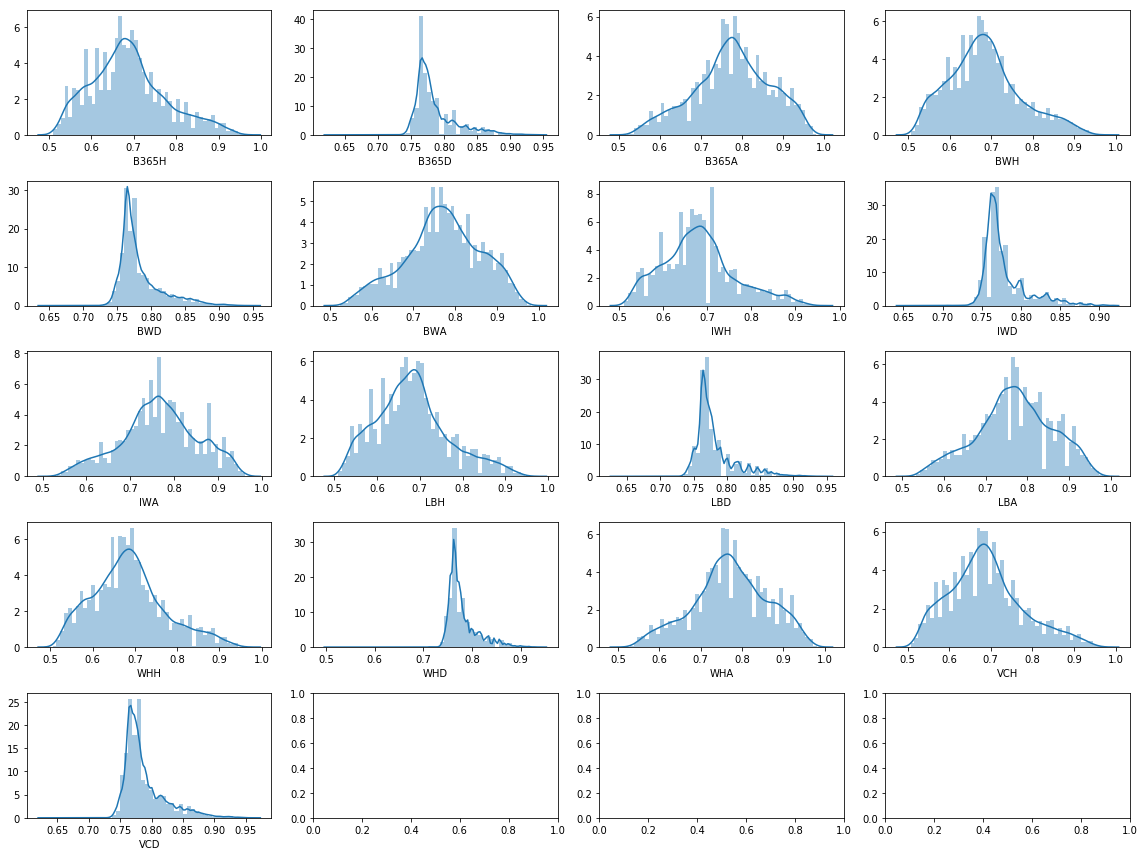

In [13]:
#Distplots of each bookie across the three categories of prediction prior to log transformation: -home wins, away win, and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

fig, ax = plt.subplots(nrows=5,ncols=4)
fig.set_size_inches(16,12)

i = 0
for column in df.loc[:,'B365H':'VCD'].columns:
    sns.distplot(df[column], ax = ax[int(i/4)][i%4])
    i+=1

fig.tight_layout()

#code from Harrison



In [14]:
def log_transform(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: np.log(x))
        
    return df

df_log_transformed = df.copy()
df_log_transformed.loc[:,'B365H':'VCH':3] = log_transform(df_log_transformed.copy().loc[:,'B365H':'VCH':3])
df_log_transformed.loc[:,'B365D':'VCD':3] = log_transform(df_log_transformed.copy().loc[:,'B365D':'VCD':3])

In [15]:
(df.B365H == df_log_transformed.B365H).sum()/len(df.B365H == df_log_transformed.B365H)



0.0

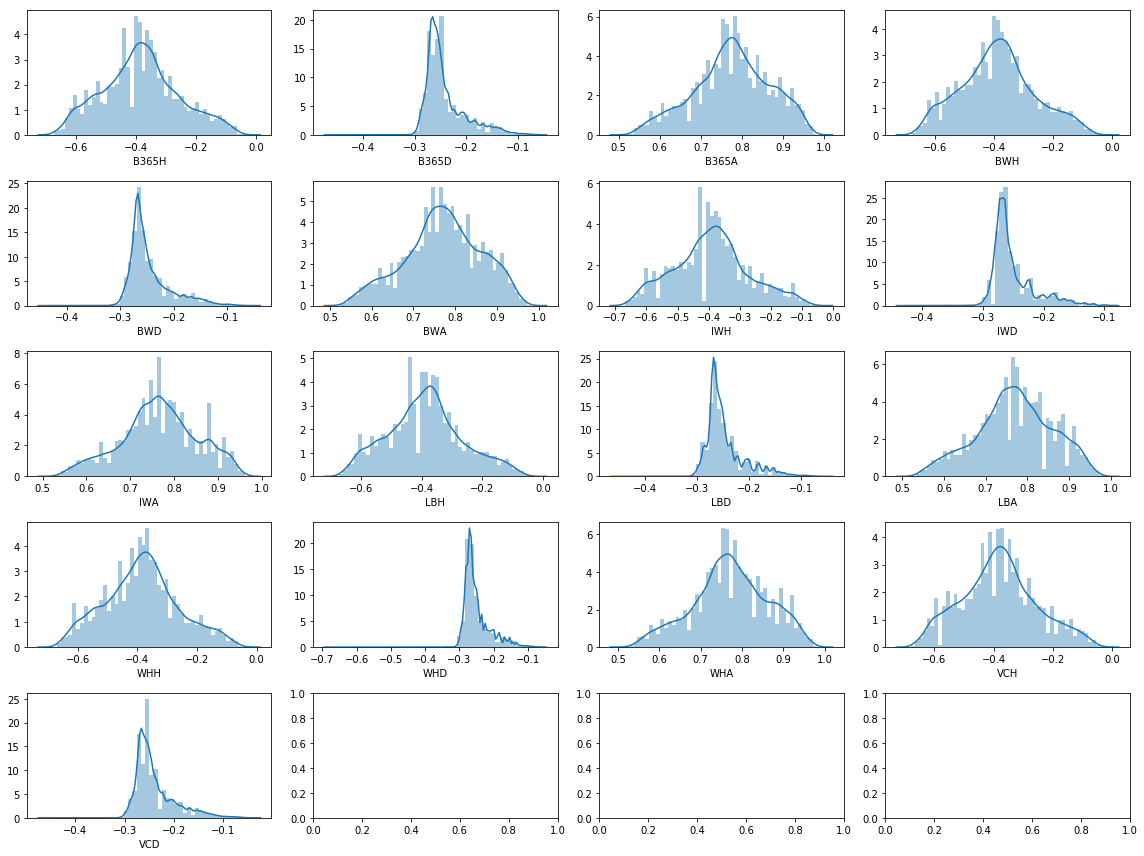

In [16]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

fig, ax = plt.subplots(nrows=5,ncols=4)
fig.set_size_inches(16,12)

i = 0
for column in df_log_transformed.loc[:,'B365H':'VCD'].columns:
    sns.distplot(df_log_transformed[column], ax = ax[int(i/4)][i%4])
    i+=1

fig.tight_layout()

#code from Harrison




In [17]:
#Just out of curiosity creating a pairplot - scatter plots of the relationships between each book with the other
#and within self for all three of the categories, away win, home win, and draw

#This pairplot shows implied probability

#sns.pairplot(df.loc[:,'B365H':'VCD'])



In [18]:
#The following pairplot is of the unconverted wagering odds
#sns.pairplot(df_copy.loc[:,'B365H':'VCD'])
             
             

In [19]:
#This creates three new dataframes to hold ttest results

draw_df = df.loc[:,'B365D':'VCD':3].drop(df.index[0:df.shape[0]])
draw_df['Index_'] = df.loc[:,'B365D':'VCD':3].columns
draw_df = draw_df.set_index('Index_')
None

away_win_df = df.loc[:,'B365A':'VCA':3].drop(df.index[0:df.shape[0]])
away_win_df['Index_'] = df.loc[:,'B365A':'VCA':3].columns
away_win_df = away_win_df.set_index('Index_')
None

home_win_df = df.loc[:,'B365H':'VCH':3].drop(df.index[0:df.shape[0]])
home_win_df['Index_'] = df.loc[:,'B365H':'VCH':3].columns
home_win_df = home_win_df.set_index('Index_')
None

#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
list_of_dataframes = [home_win_df, away_win_df, draw_df]

for bookie_df in list_of_dataframes:
    for bookie_1 in bookie_df:
        for index, bookie_2 in enumerate(bookie_df):
            if str(bookie_df)!=str(away_win_df):
                x = df_log_transformed[bookie_1]
                y = df_log_transformed[bookie_2]
            else:
                x = df[bookie_1]
                y = df[bookie_2]
                
            ttest=stats.ttest_ind(x,y)
            bookie_df[bookie_1].iloc[index] = ttest[1]
        

        #Deletes repetive values to improve heatmap visualization
        for i in range(bookie_df.shape[0]):
            for j in range(bookie_df.shape[1]):
                if j>=i:
                    bookie_df.iloc[i,j] = None
                


Text(0.5, 52.0, '')

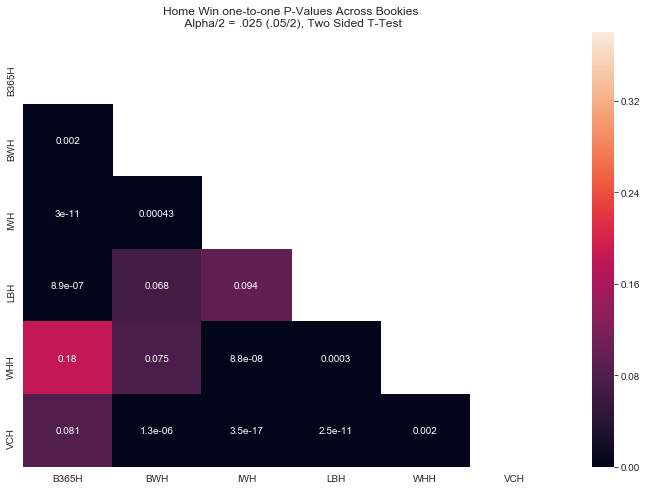

In [20]:
#This generates a heatmap of p-values for home wins
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(home_win_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Home Win one-to-one P-Values Across Bookies\n Alpha/2 = .025 (.05/2), Two Sided T-Test")
ax.patch.set_alpha(0.5)
ax.set_ylabel('')    
ax.set_xlabel('')


#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#most succeed, meaning the various bookie predictions are truly from different distributions.

#In the heatmap below the t-tests that successfully reject the null hypothesis are in dark blue.
#Lighter purple and magenta values denote failure to reject because the p-value is greater
#than .05  It should also be noted that these are individual comparisons between similar metrics 
#across individiual bookies, one to another.  There is one darker purple square with a p-value of .038 which
#does reject the null hypothesis.

#The following 5 t-tests comparisons failed to reject, meaning they come from the same underlying distribution
#at a 95% statistical confidence level for probability of a home team win:

#B365H to WHH
#B365H to VCH
#BWH to LBH
#BWH to WHH
#IWH to LBH


#key:

#B365H - Bet365
#BWH - Bet and Win
#IWH - Interwetten
#LBH - Ladbrokes
#WHH - William Hill 
#VCH - VC Bet

#"H" stands for home win



Text(0.5, 52.0, '')

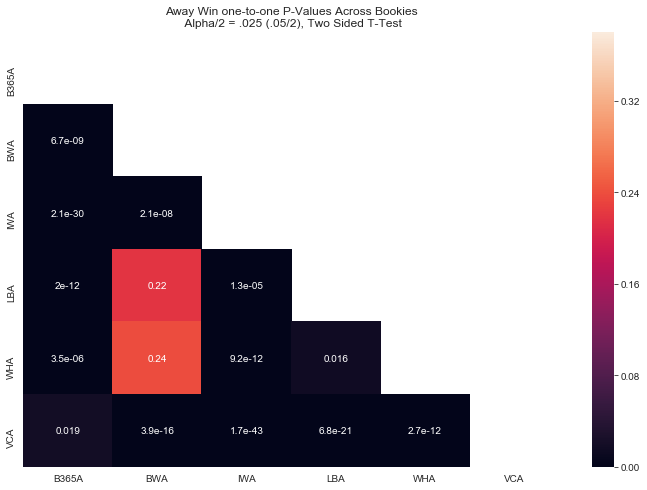

In [21]:
#This generates a heatmap of p-values for away wins

fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(away_win_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Away Win one-to-one P-Values Across Bookies\n Alpha/2 = .025 (.05/2), Two Sided T-Test")
ax.patch.set_alpha(.05)
ax.set_ylabel('')    
ax.set_xlabel('')

#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#most succeed, meaning the various bookie predictions are truly from different distributions.

#In the heatmap below the t-tests that successfully reject the null hypothesis are in dark blue.
#Purple values denote failure to reject because the p-value is greater
#than .05  It should also be noted that these are individual comparisons between similar metrics 
#across individiual bookies, one to another.  

#The following 2 t-tests comparisons failed to reject, meaning they come from the same underlying distribution
#at a 95% statistical confidence level for probability of a home team win:

#B365A to VCA
#LBA to WHA

#key:

#B365A - Bet365
#BWA - Bet and Win
#IWA - Interwetten
#LBA - Ladbrokes
#WHA - William Hill 
#VCA - VC Bet

#"A" stands for away win



Text(0.5, 52.0, '')

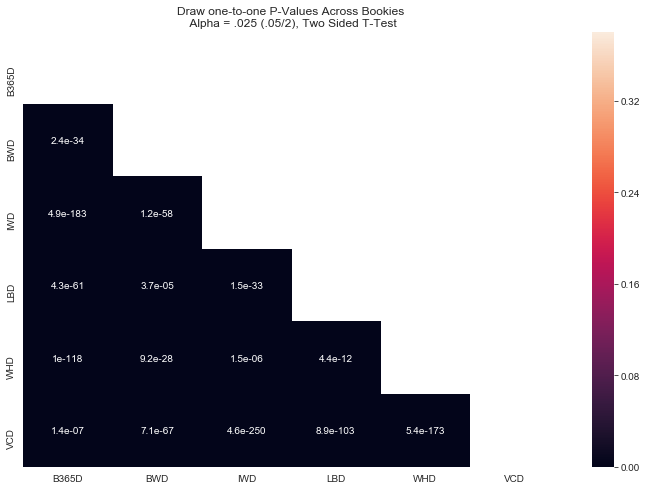

In [22]:
#This generates a heatmap of p-values for draws
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(draw_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Draw one-to-one P-Values Across Bookies\n Alpha = .025 (.05/2), Two Sided T-Test")
ax.patch.set_alpha(.05)
ax.set_ylabel('')    
ax.set_xlabel('')

#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#and all succeed, meaning the various bookie predictions are truly from different distributions.

#All ttests below reject the null hypothesis and thereby come from different underlying distributions

#key:

#B365D - Bet365
#BWD - Bet and Win
#IWD - Interwetten
#LBD - Ladbrokes
#WHD - William Hill 
#VCD - VC Bet

#"D" stands for away win


In [23]:
#Now we conduct one-way anova tests for the bookies in each category,
#home win, away win, and draw

result = stats.f_oneway(df_log_transformed.B365H, df_log_transformed.BWH, df_log_transformed.IWH, df_log_transformed.LBH, df_log_transformed.WHH, df_log_transformed.VCH)
print(' ')
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")
print(' ')

result = stats.f_oneway(df.B365A, df.BWA, df.IWA, df.LBA, df.WHA, df.VCA)
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")
print(' ')
      
stats.f_oneway(df.B365D, df_log_transformed.BWD, df_log_transformed.IWD, df_log_transformed.LBD, df_log_transformed.WHD, df_log_transformed.VCD)
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")
print(' ')
      
#For all three of my one-way ANOVA tests, the null hypothesis that the individual distributions
#come from the same underlying distribution was rejected at the 95% level of confidence.

#This means essentially there is no single common distribution that can predict all the bookie's
#behavior for all three categories of odds, home wins, away wins, and draws.
      

 
The p-value for this one way ANOVA test is 1.5648325466074877e-19
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.
 
The p-value for this one way ANOVA test is 3.3042277037498044e-51
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.
 
The p-value for this one way ANOVA test is 3.3042277037498044e-51
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.
 


In [24]:
(df.B365H == df_log_transformed.B365H).sum()/len(df.B365H == df_log_transformed.B365H)


0.0

In [25]:
#Two way anova testing:

#home_win_df_anova
hold_list = []
df_list = [home_win_df, away_win_df, draw_df]
home_win_df_anova = home_win_df
away_win_df_anova = away_win_df
draw_df_anova = draw_df
anova_df_list = [home_win_df_anova, away_win_df_anova, draw_df_anova]

match_list = [] #checking to see which database is beign called
for index, dfl_item in enumerate(df_list):
    for bookie in anova_df_list[index]:
        formula = f'{bookie} ~ ' +' + '.join([bookie for bookie in anova_df_list[index].drop(bookie, axis=1).columns])
        if str(dfl_item)==str(away_win_df):
            match_list.append([index, "df"])
            model = sm.ols(formula, df).fit()
        else:
            #switch commenting to choose between log transformed or not
            #model = sm.ols(formula, df).fit()
            model = sm.ols(formula, df_log_transformed).fit()
            match_list.append([index, "df_log_transformed"])
            
        aov_table = sm2.stats.anova_lm(model, typ=2)
        for bookie_2 in anova_df_list[index].drop(bookie, axis=1).columns:
            anova_df_list[index].loc[bookie][bookie_2] = aov_table.loc[bookie_2]['PR(>F)']
                
    #Deletes repetive values to improve heatmap visualization
    for i in range(anova_df_list[index].shape[0]):
        for j in range(anova_df_list[index].shape[1]):
            if j>=i:
                anova_df_list[index].iloc[i,j] = None
                    

home_win_df_anova= anova_df_list[0]
away_win_df_anova = anova_df_list[1]
draw_df_anova = anova_df_list[2]
#match_list


Text(0.5, 52.0, '')

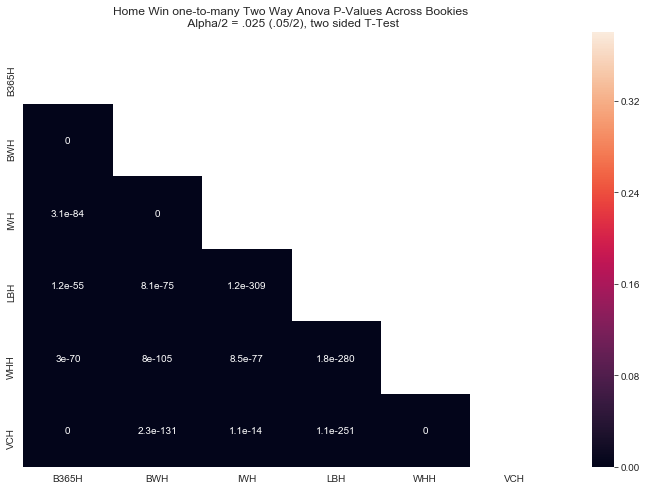

In [26]:
#This generates a heatmap for home win two way anova tests
#all distributions reject the null hypothesis when each is compared to the rest of the others
#this means they do not come from the same underlying distribution

fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(home_win_df_anova, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Home Win one-to-many Two Way Anova P-Values Across Bookies\n Alpha/2 = .025 (.05/2), two sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')



Text(0.5, 52.0, '')

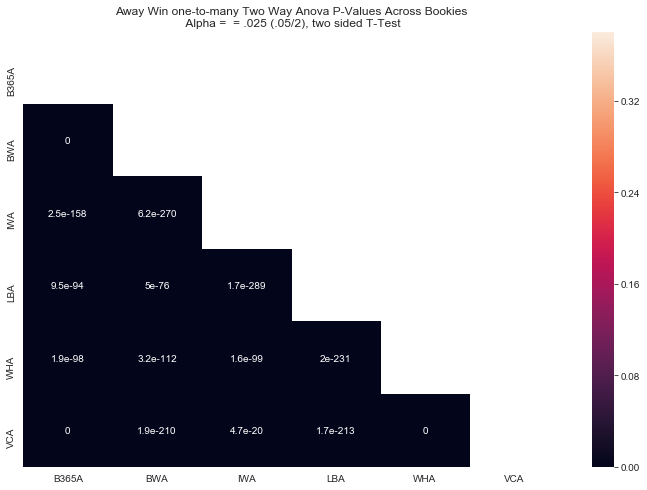

In [27]:
#This generates a heatmap for away win two way anova tests
#all distributions reject the null hypothesis when each is compared to the rest of the others
#this means they do not come from the same underlying distribution

fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(away_win_df_anova, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Away Win one-to-many Two Way Anova P-Values Across Bookies\n Alpha =  = .025 (.05/2), two sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')



Text(0.5, 52.0, '')

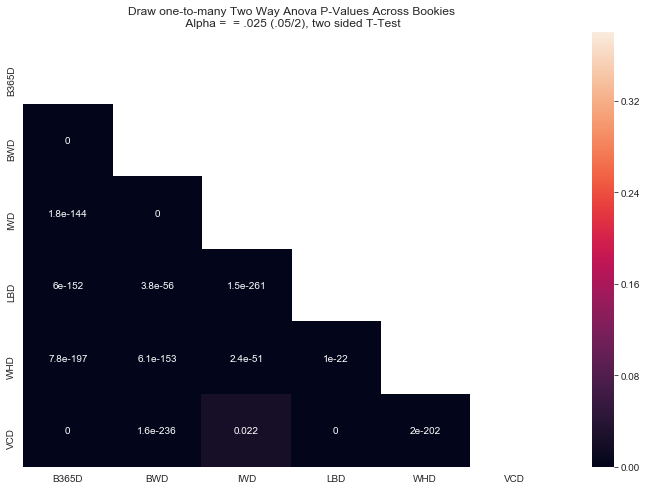

In [28]:
#This generates a heatmap for draw two way anova test
#All distributions reject the null hypothesis when each is compared to the rest of the others
#this means they do not come from the same underlying distribution


fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(draw_df_anova, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Draw one-to-many Two Way Anova P-Values Across Bookies\n Alpha =  = .025 (.05/2), two sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')



# Athletic Measures Vs. Soccer Skills




In [29]:
#this function establishes a sql connection and gets a database
#I got this from Harrison 

def sql_query_to_df(cursor, sql_query):
    c.execute(sql_query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df




In [30]:
#Load up information from Match and Player_Attributes Databases
ath_df = sql_query_to_df(c, """SELECT * FROM Player_Attributes""")


In [31]:
#Checking for null values - there are none
ath_df.isna().sum().sum()


47301

In [32]:
#ath_df.dtypes



In [33]:
ath_df.dropna(inplace=True)
ath_df.drop_duplicates(subset='player_fifa_api_id', inplace=True)
ath_df.drop_duplicates(subset='player_api_id', inplace=True)




In [34]:
#Here are the athletic abilities we will look at:
ath_list =  ['acceleration','sprint_speed','agility','reactions',
       'balance', 'jumping', 'stamina', 'strength']


#here are the soccer skills we will look at:
skills_list = ath_df.loc[:,'potential': 'sliding_tackle'].drop(['acceleration','sprint_speed','agility','reactions',
       'balance', 'jumping', 'stamina', 'strength','preferred_foot', 
            'attacking_work_rate', 'defensive_work_rate','vision','potential','shot_power','volleys','curve'], axis=1).columns


#instantiate a dataframe with zeros to hold pvalues
qualities_df = pd.DataFrame(index=[skills_list], columns=[ath_list])
for col in qualities_df.columns:
    qualities_df[col].values[:] = 0


In [47]:
log_transform_test(ath_df[skills_list])
#False indicates a log transformation will not improve normality
#We decided not to log transform due to 10/16 of these column tests resulting in false


[['crossing', False],
 ['finishing', True],
 ['heading_accuracy', False],
 ['short_passing', False],
 ['dribbling', False],
 ['free_kick_accuracy', False],
 ['long_passing', False],
 ['ball_control', False],
 ['long_shots', False],
 ['aggression', False],
 ['interceptions', True],
 ['positioning', False],
 ['penalties', False],
 ['marking', True],
 ['standing_tackle', True],
 ['sliding_tackle', True]]

In [40]:
log_transform_test(ath_df[ath_list])



[['acceleration', False],
 ['sprint_speed', False],
 ['agility', False],
 ['reactions', False],
 ['balance', False],
 ['jumping', False],
 ['stamina', False],
 ['strength', False]]

In [126]:
#This will populate two df's, one of pvalues and one of the difference between means

#function takes in the main_df, a p-values holder df, the percentage desired for split (must be 75, 50, or 25),
#a list of athletic measures and a list of osccer skills
def ath_to_skill_ttest(ath_df, qualities_df, top_percent, ath_list, skills_list):
    
    #setting up empty dictionary
    dict_means = {}
    
    #reset values to zero
    for col in qualities_df.columns:
        qualities_df[col].values[:] = 0
    
    #creating a string with % after the percent
    #this is needed for grabbing values off series.describe()
    top_percent_string = str(top_percent)+'%'
    bottom_percent_string = str(100-top_percent)+'%'
    
    #create columns classifying players into upper and lower groups for each athletic ability
    for ath in ath_list:
        ath_df[ath+'_top'+top_percent_string]=ath_df[ath]>= ath_df[ath].describe()[top_percent_string]
        ath_df[ath+'_bottom'+bottom_percent_string]=ath_df[ath]< ath_df[ath].describe()[top_percent_string]

    #this is a dictionary that hold the 25/75 splits
    dict_skill_split = {}
    for i, ath in enumerate(ath_list):
        for j, skill in enumerate(skills_list):
            
            #Creates a dictionary entry for each ath/skill combo with an array the skill of top quartile of the ath
            #and array of the skill of the bottom 75
            dict_skill_split.update({ath+skill : [ath_df.loc[ath_df[ath+'_top'+top_percent_string]][skill], 
                                           ath_df.loc[ath_df[ath+'_bottom'+bottom_percent_string]][skill]]})
            
            dict_means.update({ath+skill : ath_df.loc[ath_df[ath+'_top'+top_percent_string]][skill].mean()- 
                                           ath_df.loc[ath_df[ath+'_bottom'+bottom_percent_string]][skill].mean()})
                

                                                          
    
#This loops through the qualities to conduct individual one-to-one ttests
    fail_reject_list = []
    reject_list = []
    mean_df = qualities_df.copy()                         
    for a, ath in enumerate(ath_list):
        for s, skill in enumerate(skills_list):
                
                              
                x = dict_skill_split[ath+skill][0] #skill level of top of the ath group
                y = dict_skill_split[ath+skill][1] #skill level of bottom of the ath group
                ttest=stats.ttest_ind(x,y) #two sided ttest
                
                #checking for very small numbers and assigning to zero
                if ttest[1]<float('1.0e-7'):
                    qualities_df.iloc[s, a] = 0.0
                else:
                    qualities_df.iloc[s, a] = ttest[1]
                    
                #checking to see if null hypothesis has been rejected
                if (ttest[1] > .025):
                    fail_reject_list.append([ath,skill, dict_skill_split[ath+skill][0],dict_skill_split[ath+skill][1]])
                    mean_df.iloc[s, a] = dict_means[ath+skill]
                else:
                    reject_list.append([ath,skill, dict_skill_split[ath+skill][0],dict_skill_split[ath+skill][1]])
                    mean_df.iloc[s, a] = dict_means[ath+skill]
                    
                pvalues_df = qualities_df
    return pvalues_df, mean_df, reject_list, fail_reject_list     

pvalues_df_7525, mean_df_7525, reject_list_7525, fail_reject_list_7525 = ath_to_skill_ttest(ath_df, qualities_df, 75, ath_list, skills_list)

#I was having issues with any earlier dataframe that had been assigned by this function getting reassigned
#every time I ran it so for now I have solved it by forcing pandas to make copies
df_7525 = pvalues_df_7525.copy()
mdf_7525 = mean_df_7525.copy()

pvalues_df_5050, mean_df_5050, reject_list_5050, fail_reject_list_5050 = ath_to_skill_ttest(ath_df, qualities_df, 50, ath_list, skills_list)
df_5050 = pvalues_df_5050.copy()
mdf_5050 = mean_df_5050.copy()

pvalues_df_2575, mean_df_2575, reject_list_2575, fail_reject_list_2575 = ath_to_skill_ttest(ath_df, qualities_df, 25, ath_list, skills_list)
df_2575 = pvalues_df_2575.copy()
mdf_2575 = mean_df_2575.copy()

#conveting values from objects to floats so they can be plotted
df_list = [df_7525, df_5050, df_2575, mdf_7525, mdf_5050, mdf_2575]
for dff in df_list:
    for column in dff.columns:
        dff[column] = pd.to_numeric(dff[column])


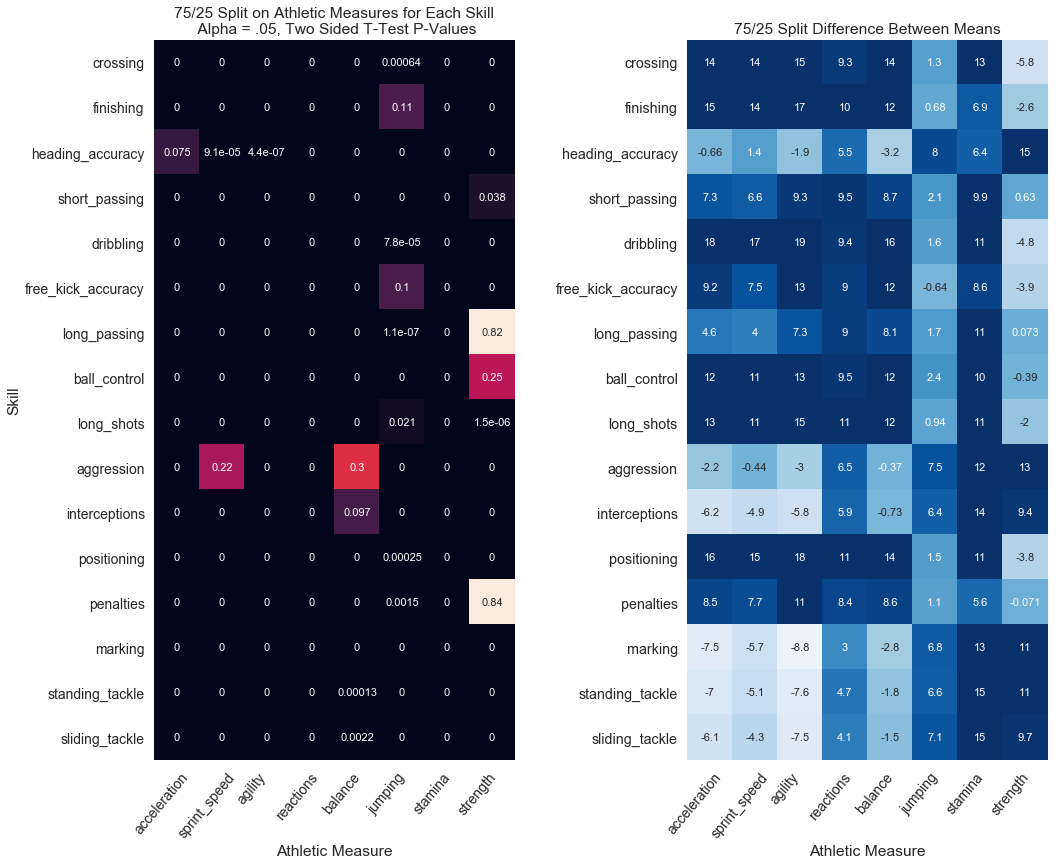

In [127]:
# 75/25 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_7525, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_7525, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("75/25 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("75/25 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()

#https://stackoverflow.com/questions/28615887/how-to-move-a-ticks-label-in-matplotlib



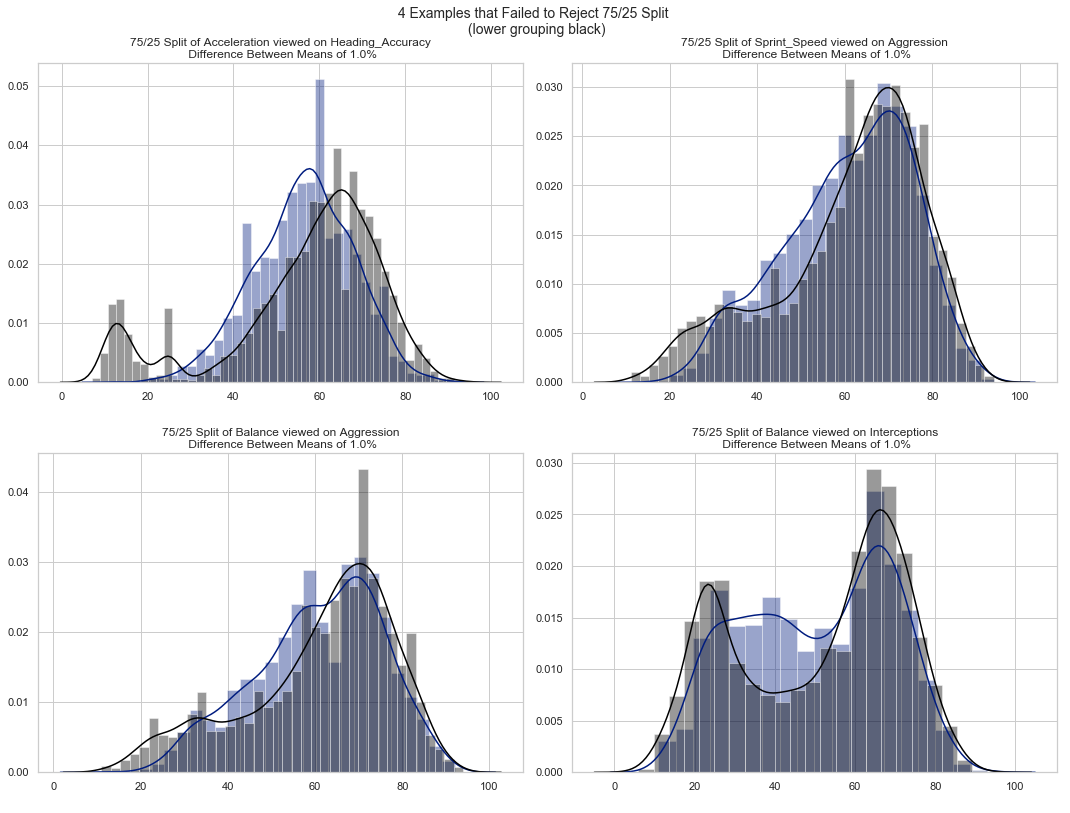

In [264]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(font_scale=1.3)
sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("4 Examples that Failed to Reject 75/25 Split \n (lower grouping black)", fontsize=14)


i = 0
p = fail_reject_list_7525[:4]
for q in p:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="black", ax = ax[int(i/2)][i%2]).set_title(f"75/25 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1

fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison



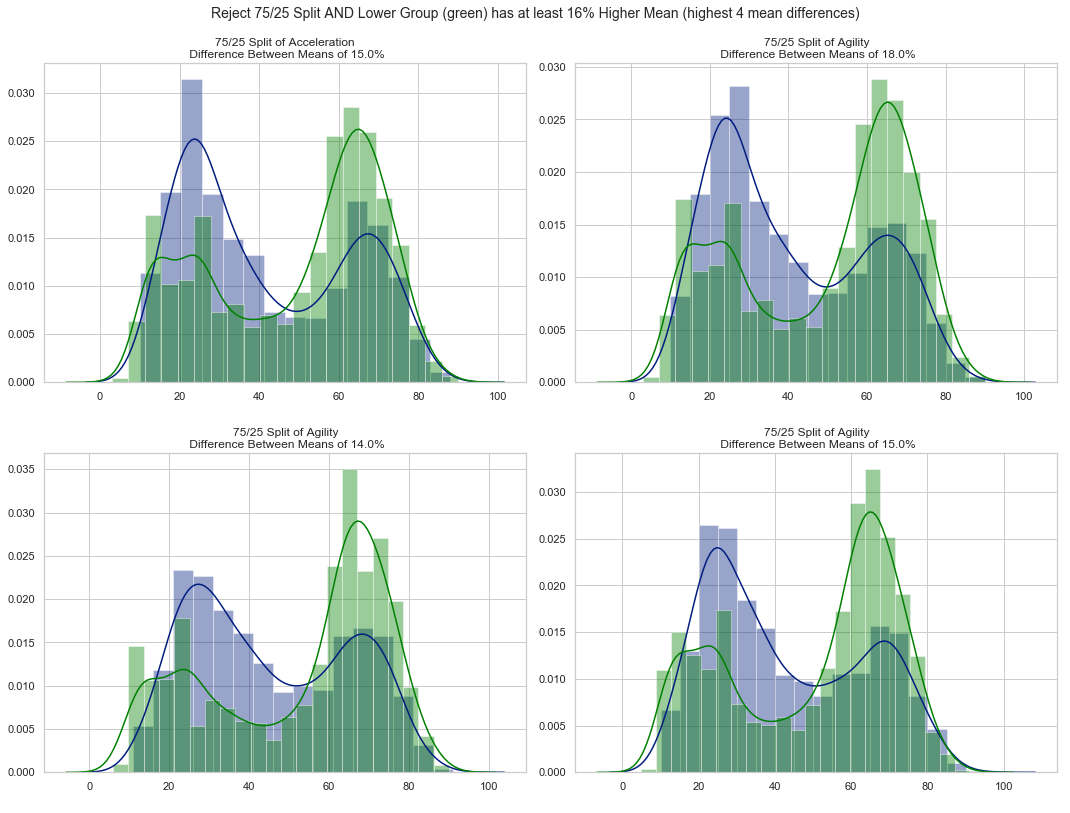

In [270]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 75/25 Split AND Lower Group (green) has at least 16% Higher Mean (highest 4 mean differences)", fontsize=14)


i = 0
for q in reject_list_7525:
    if q[3].mean()/q[2].mean() >= 1.16 :
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="green", ax = ax[int(i/2)][i%2]).set_title(f"75/25 Split of {q[0].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison


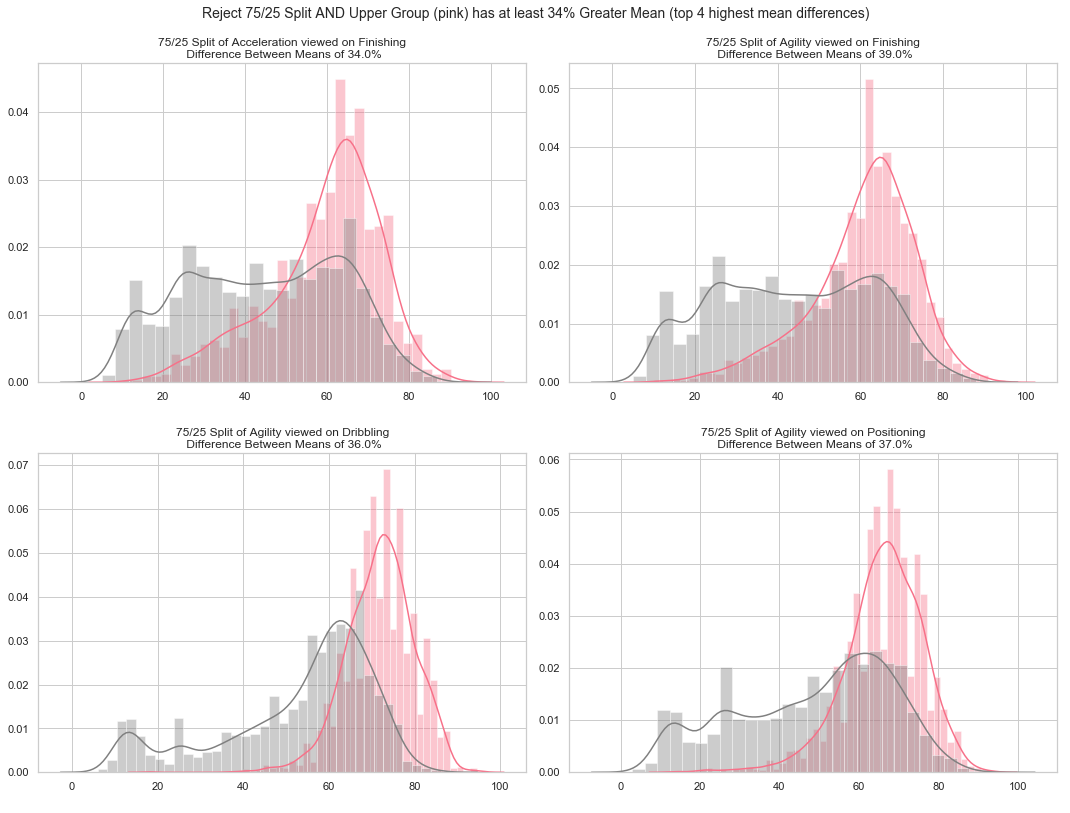

In [258]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="husl", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 75/25 Split AND Upper Group (pink) has at least 34% Greater Mean (top 4 highest mean differences)", fontsize=14)


i = 0
for q in reject_list_7525:
    if q[2].mean()/q[3].mean() >= 1.34:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="grey", ax = ax[int(i/2)][i%2]).set_title(f"75/25 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {round((round(q[2].mean()/q[3].mean(),2)-1)*100,2)}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison

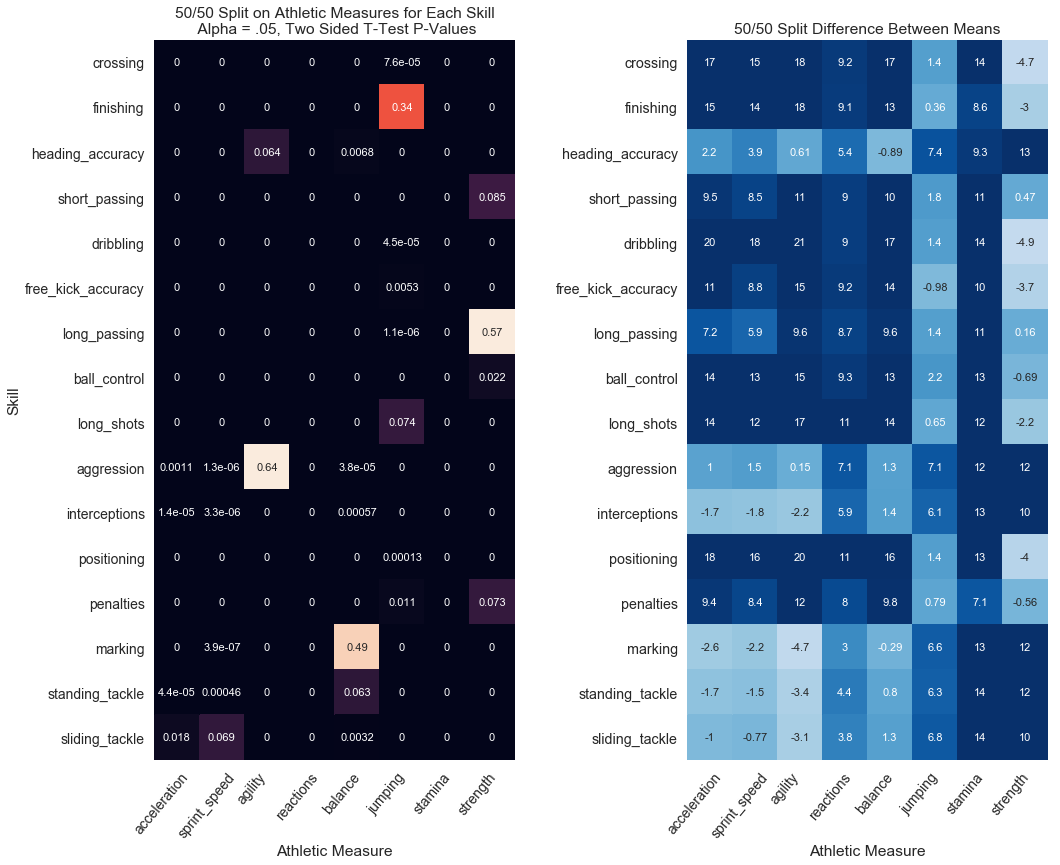

In [130]:
#50/50 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_5050, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_5050, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("50/50 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("50/50 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()





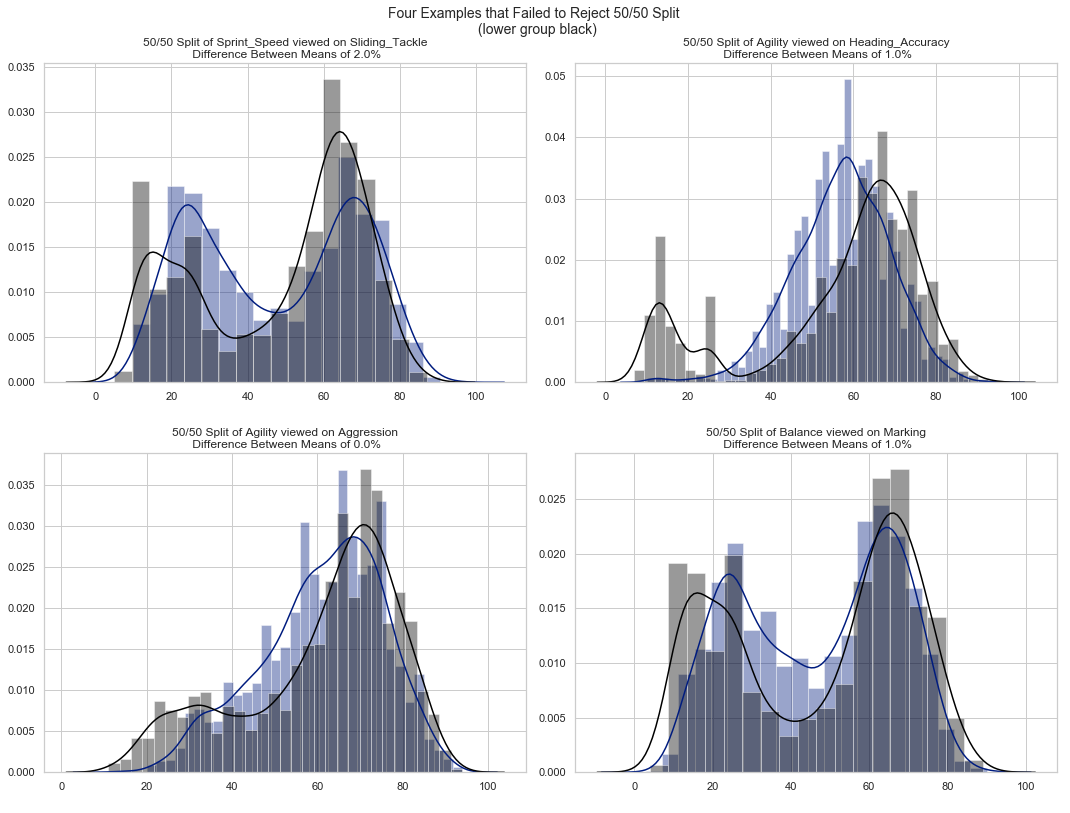

In [263]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Four Examples that Failed to Reject 50/50 Split \n (lower group black)", fontsize=14)


i = 0
p = fail_reject_list_5050[:4]
for q in p:
        q[3].name = " "
        sns.distplot(q[2], label = "sdf", ax = ax[int(i/2)][i%2]).set_title(f"Upper 50% of {q[0].title()} on {q[1].title()}")
        sns.distplot(q[3], color = "black", ax = ax[int(i/2)][i%2]).set_title(f"50/50 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison

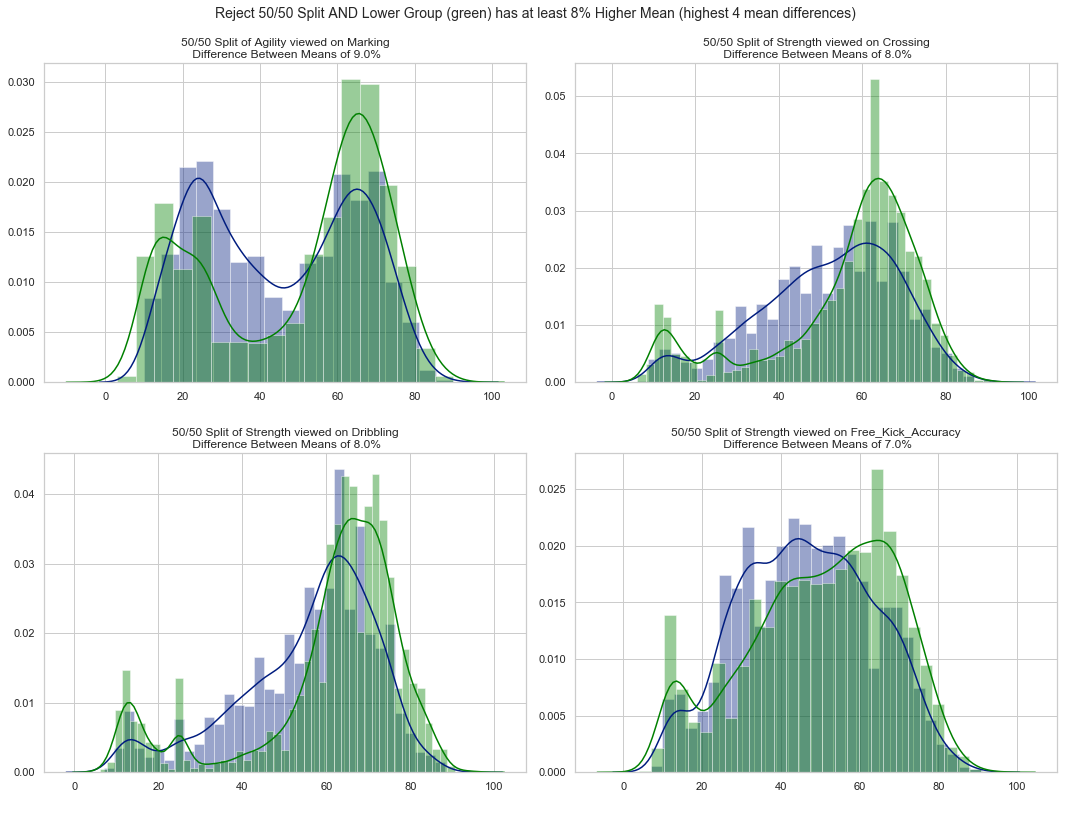

In [269]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 50/50 Split AND Lower Group (green) has at least 8% Higher Mean (highest 4 mean differences)", fontsize=14)


i = 0
for q in reject_list_5050:
    if q[3].mean()/q[2].mean() >= 1.08:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="green", ax = ax[int(i/2)][i%2]).set_title(f"50/50 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison


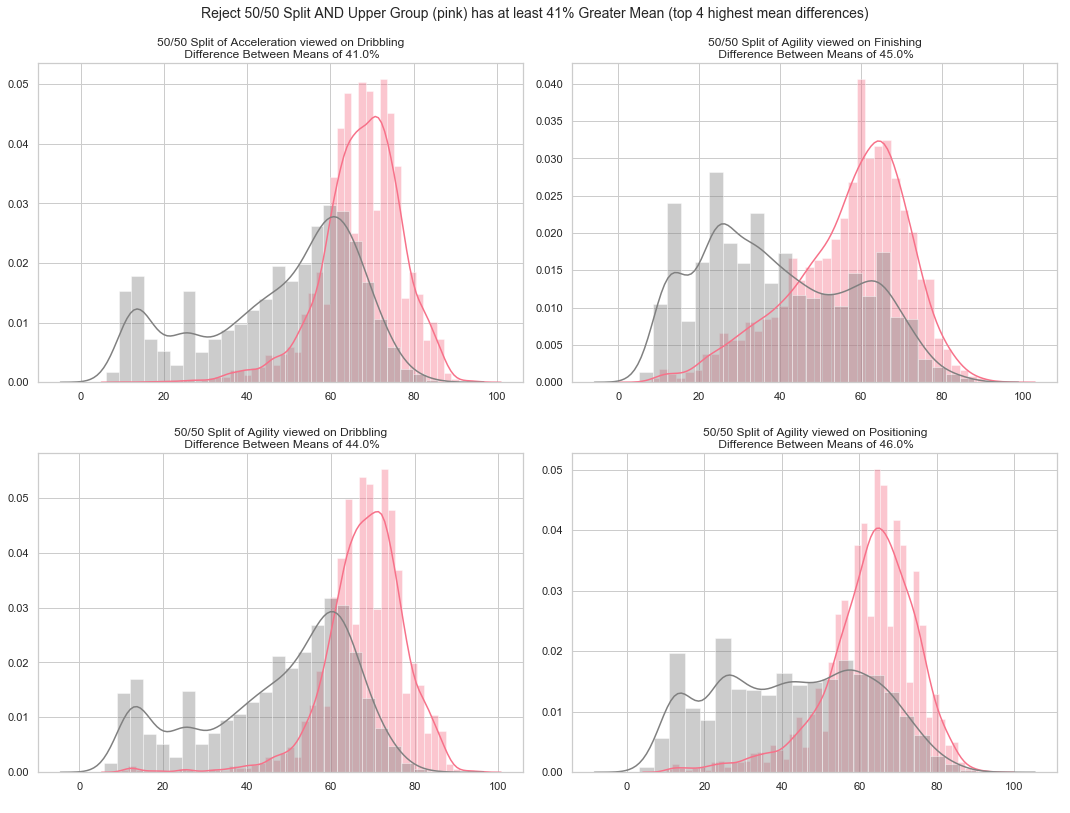

In [259]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="husl", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 50/50 Split AND Upper Group (pink) has at least 41% Greater Mean (top 4 highest mean differences)", fontsize=14)


i = 0
for q in reject_list_5050:
    if q[2].mean()/q[3].mean() >= 1.41:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="grey", ax = ax[int(i/2)][i%2]).set_title(f"50/50 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {round((round(q[2].mean()/q[3].mean(),2)-1)*100,2)}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison

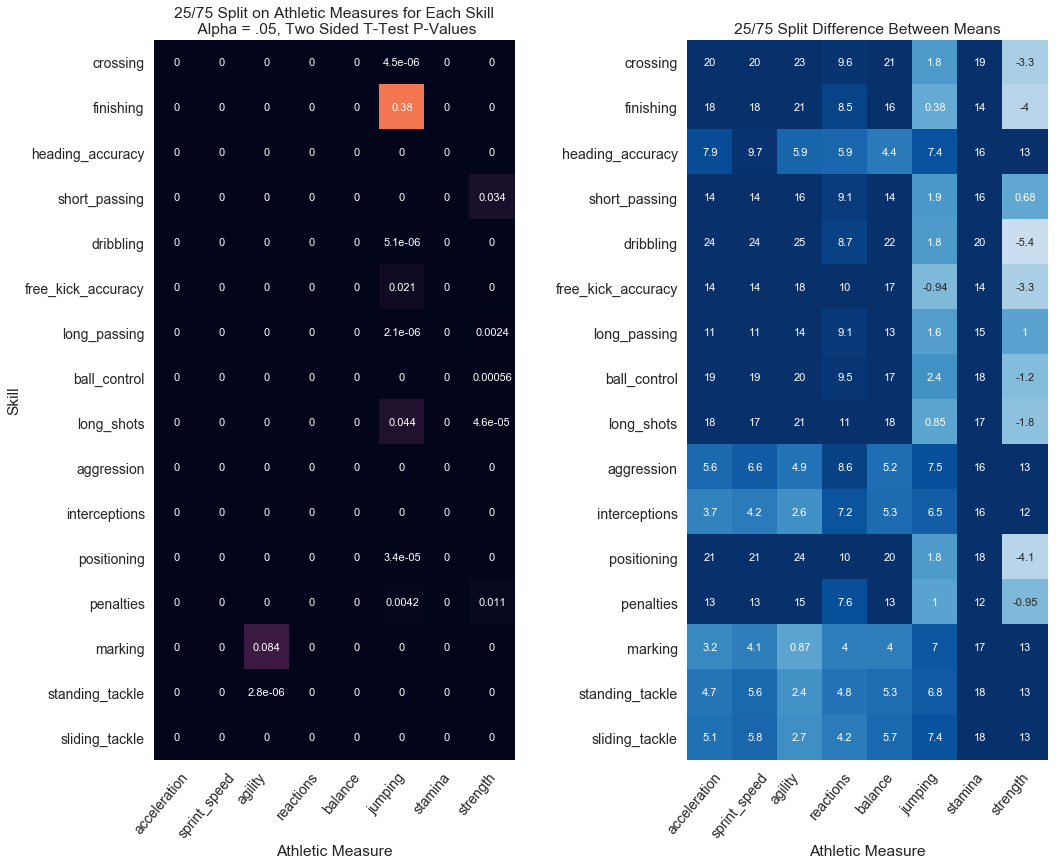

In [132]:
#25/75 Split Seaborn Heatmap

sns.set(font_scale=1.3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,20))
sns.heatmap(df_2575, vmin=0, vmax=.53, annot = True, ax = ax1, square = True, annot_kws={"fontsize":11}, cbar= False)
sns.heatmap(mdf_2575, vmin=-10, vmax=10, annot = True, cmap='Blues', ax = ax2, square = True, annot_kws={"fontsize":11}, cbar =False)

#ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(50)
    
# Create offset transform by 5 points in x direction
dx = -15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
ax1.set_title("25/75 Split on Athletic Measures for Each Skill\n Alpha = .05, Two Sided T-Test P-Values")
ax2.set_title("25/75 Split Difference Between Means")
ax1.set_ylabel('Skill')    
ax2.set_ylabel(' ')
ax1.set_xlabel('Athletic Measure')
ax2.set_xlabel('Athletic Measure')
fig.tight_layout()





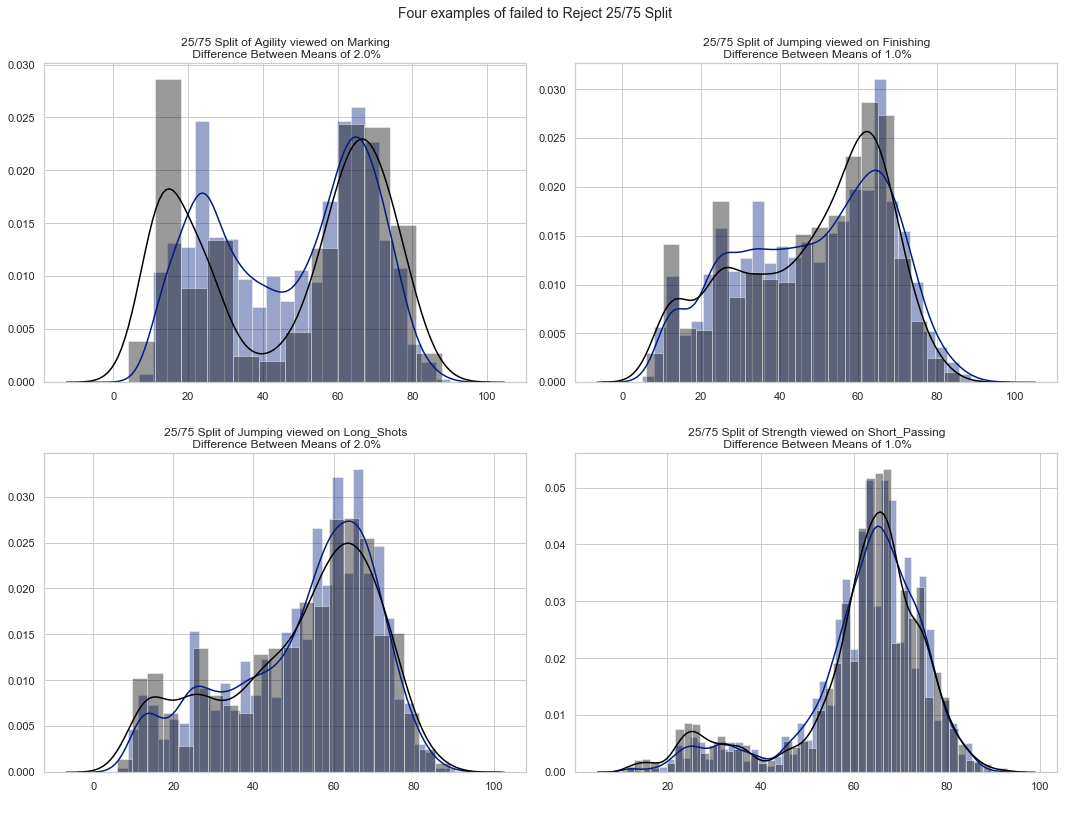

In [265]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Four examples of failed to Reject 25/75 Split", fontsize=14)


i = 0
for q in fail_reject_list_2575:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="black", ax = ax[int(i/2)][i%2]).set_title(f"25/75 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison


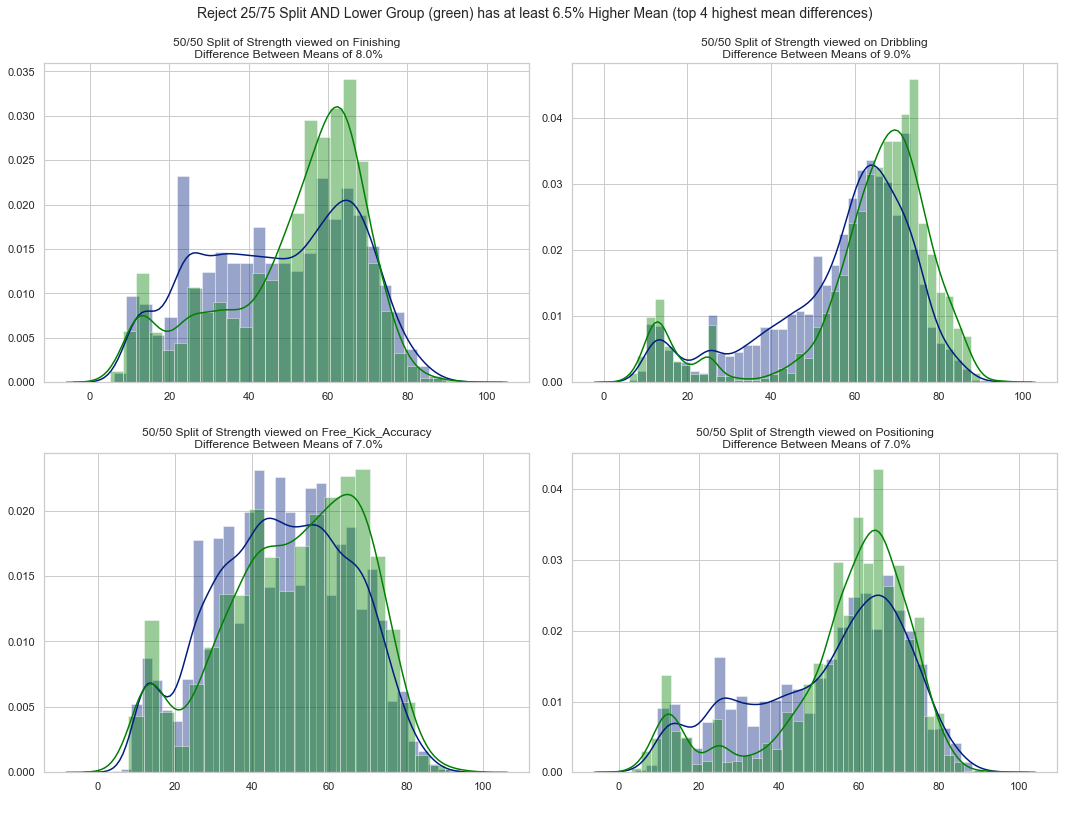

In [268]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="dark", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 25/75 Split AND Lower Group (green) has at least 6.5% Higher Mean (top 4 highest mean differences)", fontsize=14)


i = 0
for q in reject_list_2575:
    if q[3].mean()/q[2].mean() >= 1.065:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="green", ax = ax[int(i/2)][i%2]).set_title(f"50/50 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison




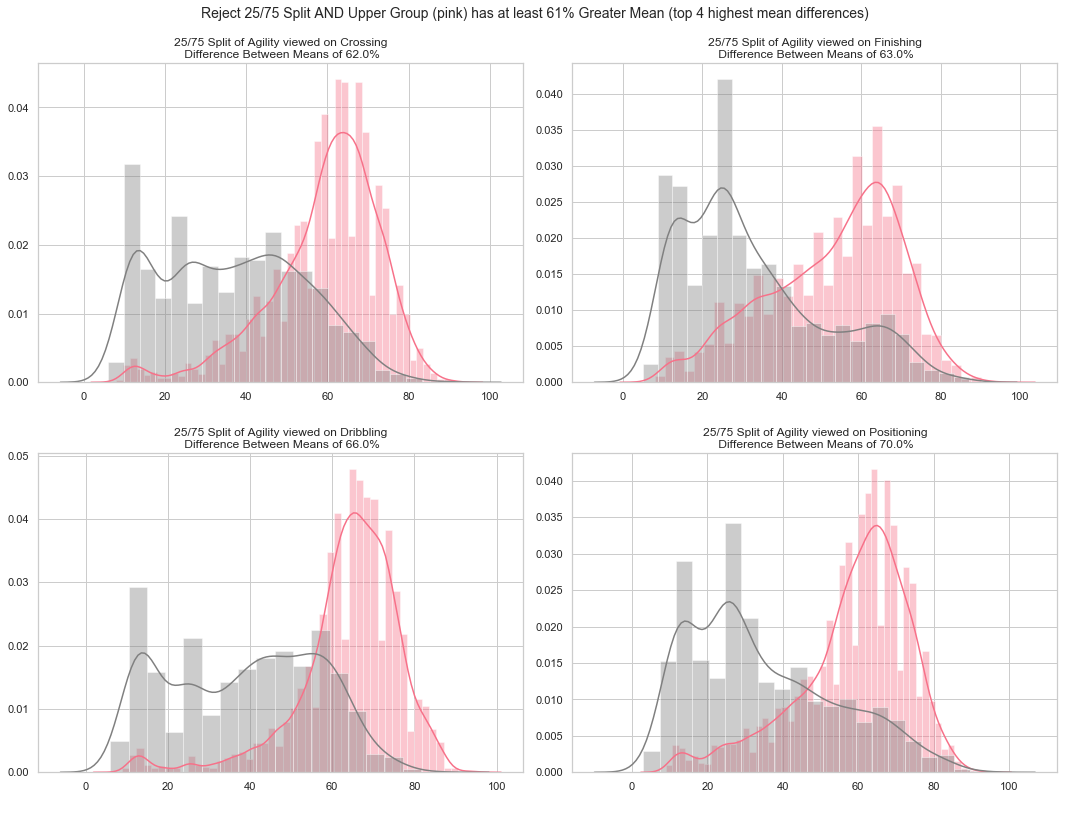

In [267]:
#Distplots of each bookie across the three categories of prediction AFTER log transformation ON -home wins and draw
#these plots visually appear fairly normal - though further testing for normality could still be done

sns.set(style="whitegrid", palette="husl", color_codes=True)
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16,12)
fig.suptitle("Reject 25/75 Split AND Upper Group (pink) has at least 61% Greater Mean (top 4 highest mean differences)", fontsize=14)


i = 0
for q in reject_list_2575:
    if q[2].mean()/q[3].mean() >= 1.61:
        q[3].name = " "
        sns.distplot(q[2], ax = ax[int(i/2)][i%2]).set_title(f" ")
        sns.distplot(q[3], color="grey", ax = ax[int(i/2)][i%2]).set_title(f"25/75 Split of {q[0].title()} viewed on {q[1].title()}\n Difference Between Means of {abs(round((round(q[2].mean()/q[3].mean(),2)-1)*100,2))}%")
    
        i+=1


fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=1)


#code from Harrison